In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.applications.vgg16 import preprocess_input 

# clustering and dimension reduction
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload
from src.dataLoader import dataLoader
from src.utils import image_utils, ismember

from src.preprocessing import imadjust,imagecrop,imagePaddingByShape


# Loading full dataset

In [3]:
dataset = dataLoader("../dataset")

fileNameList = [str(imgIdx)+".jpg" for imgIdx in range(500,1001)]
imageFileList = dataset.LoadFileList(fileNameList=fileNameList)

In [4]:
class FeatureExtraction():
    def __init__(self, imageFileList:list):
        self.imageFileList = imageFileList
        model = VGG16()
        self.model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
        self.featureDict = {}
        self.fearutesData = np.array([])
        self.reducedFeature = np.array([])

    def extract_features(self, file, model):
        # load the image as a 224x224 array
        img = load_img(file, target_size=(224,224))
        # convert from 'PIL.Image.Image' to numpy array
        img = np.array(img) 
        # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
        reshaped_img = img.reshape(1,224,224,3) 
        # prepare image for model
        imgx = preprocess_input(reshaped_img)
        # get the feature vector
        features = model.predict(imgx, use_multiprocessing=True)
        return features
        
    def getFullFeature(self):
        for image_path in self.imageFileList:
            # try to extract the features and update the dictionary
            try:
                feat = self.extract_features(image_path,self.model)
                self.featureDict[image_path] = feat
            # if something fails, save the extracted features as a pickle file (optional)
            except:
                pass
        self.imageFileList = np.array(list(self.featureDict.keys()))
        # get a list of just the features
        self.fearutesData = np.array(list(self.featureDict.values())).reshape(-1,4096)
        print(self.fearutesData.shape)
        return self.fearutesData

    def getReducedFeature(self,n_components:int=100):
        pca = PCA(n_components=n_components)
        feat = self.getFullFeature()
        pca.fit(feat)
        self.reducedFeature = pca.transform(feat)
        print(f"Components before PCA: {feat.shape[1]}")
        print(f"Components after PCA: {pca.n_components}")

        plt.figure(figsize=(10,5))
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance');
        plt.show()
        return self.reducedFeature

In [5]:
# ori_dataset = []

# for image_path in imageFileList:
#     # get RGB image
#     color_image = image_utils().get_image(image_path, image_scale=cv2.COLOR_BGR2RGB, is_gray=False)
#     ori_dataset.append(color_image)

# Initial Feature extraction on full dataset

(501, 4096)
Components before PCA: 4096
Components after PCA: 100


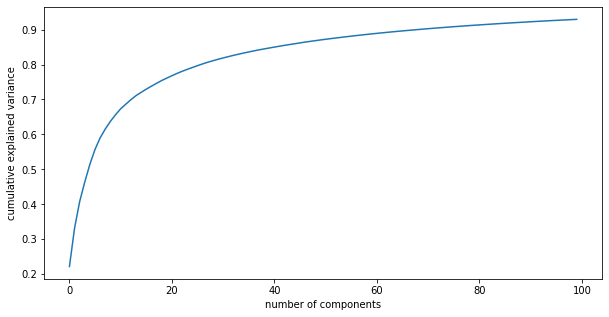

In [24]:
dataset_1st_ReducedFeatures = FeatureExtraction(imageFileList).getReducedFeature(n_components=100)

# Clustering

In [7]:
class Clustering():
    def __init__(
        self, 
        model, 
        Data:np.ndarray, 
        fileLocations:list, 
        NumCluster:int=5) -> None:
        self.model = model
        self.Data = Data
        self.fileLocations = fileLocations
        self.groups = {}
        self.NumCluster = NumCluster

    def train(self):
        # fit the model
        self.model.fit(self.Data)
        # assign a cluster to each example
        yhat = self.model.predict(self.Data)
        # holds the cluster id and the images { id: [images] }
        for file, cluster in zip(self.fileLocations,yhat):
            if cluster not in self.groups.keys():
                self.groups[cluster] = []
                self.groups[cluster].append(file)
            else:
                self.groups[cluster].append(file)
        return self

    def display_cluster(self,no_of_col:int = 10):
        for i in range(0,self.NumCluster):
            filePaths_row = np.array(self.groups[i])
            num = filePaths_row.shape[0]
            r = np.floor(num/float(no_of_col))

            print("cluster "+str(i))
            print(str(num)+" elements")

            plt.figure(figsize=(10,10))
            plt.axis('off')
            for k in range(0, num):
                plt.subplot(r+1, no_of_col, k+1)
                image = load_img(filePaths_row[k])
                plt.imshow(image, cmap='gray')
                plt.axis('off')
            plt.show()

In [25]:
NumCluster = 6

# KMeans clustering

cluster 0
24 elements


D:\Anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


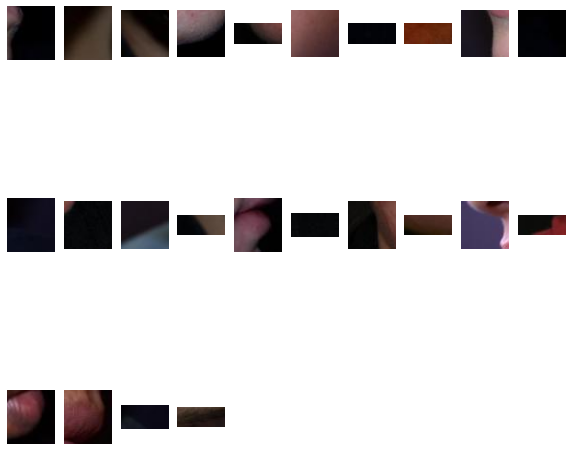

cluster 1
107 elements


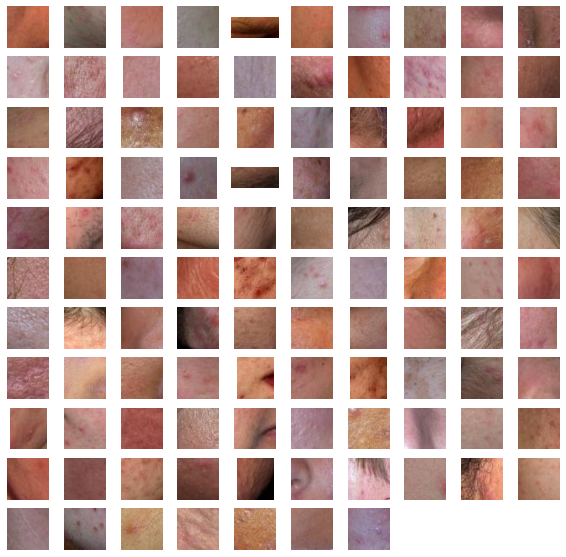

cluster 2
71 elements


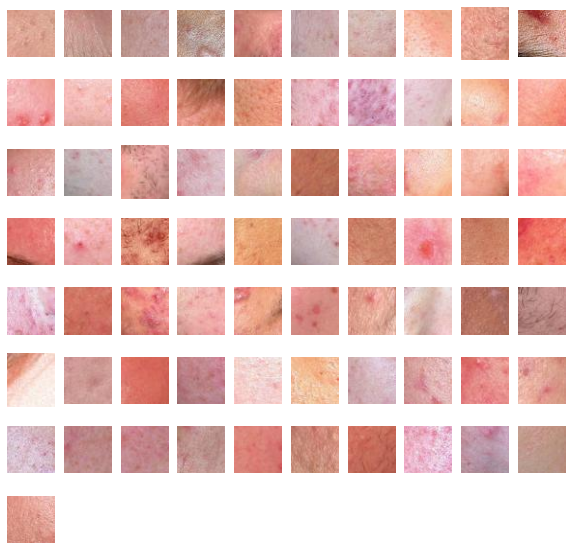

cluster 3
74 elements


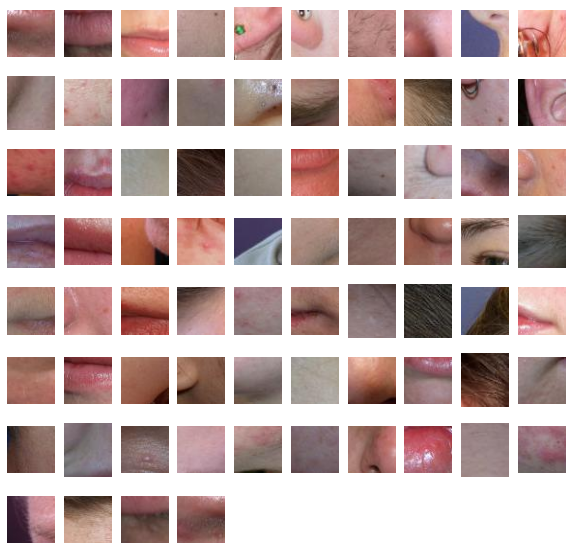

cluster 4
51 elements


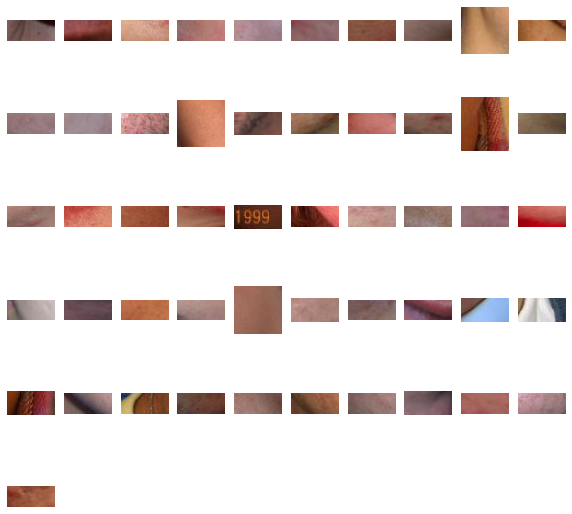

cluster 5
89 elements


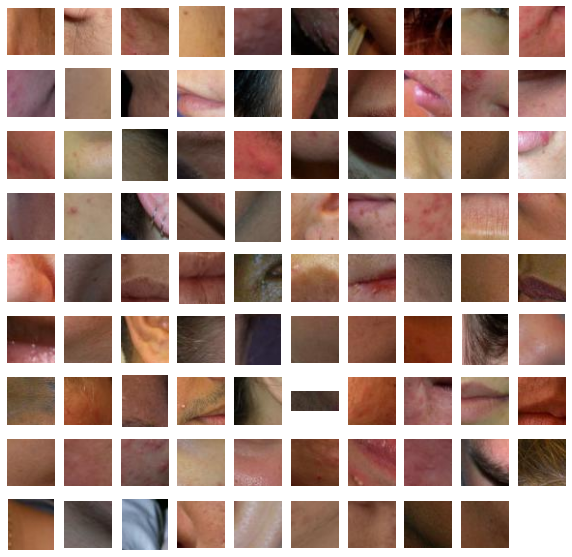

cluster 6
39 elements


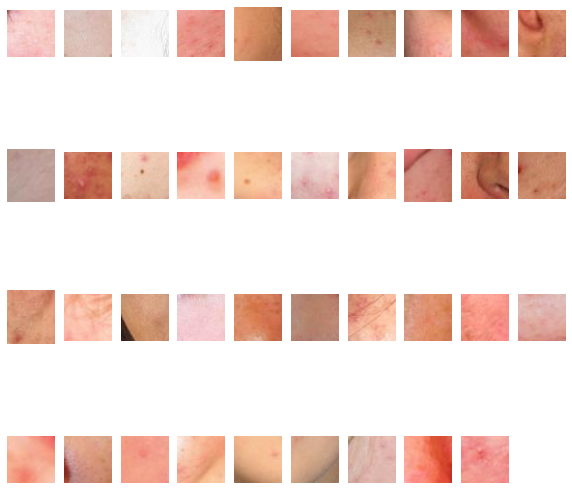

cluster 7
46 elements


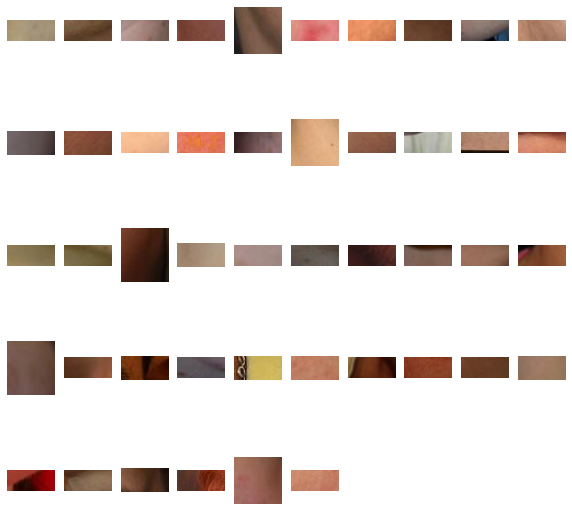

In [9]:
from sklearn.cluster import KMeans

kmeans = Clustering(
    KMeans(n_clusters=NumCluster,init='random'),
    dataset_1st_ReducedFeatures,
    imageFileList,
    NumCluster=NumCluster
    ).train()
kmeans.display_cluster(no_of_col=10)

# Gaussian Mixture clustering

cluster 0
94 elements


D:\Anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


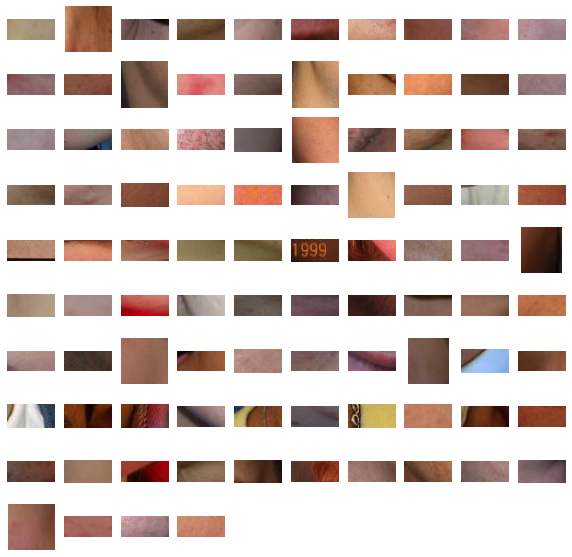

cluster 1
98 elements


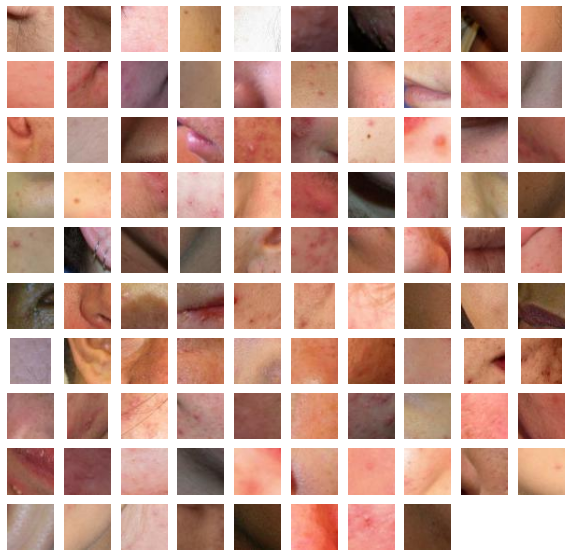

cluster 2
110 elements


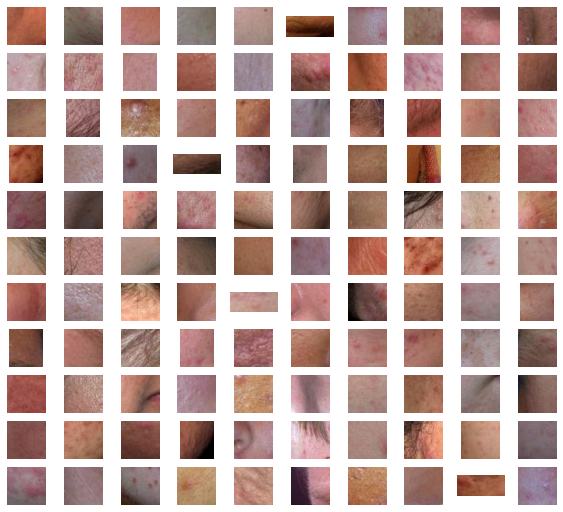

cluster 3
75 elements


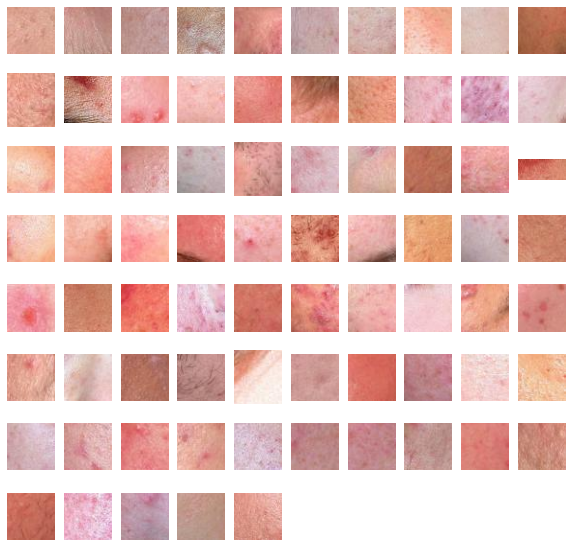

cluster 4
96 elements


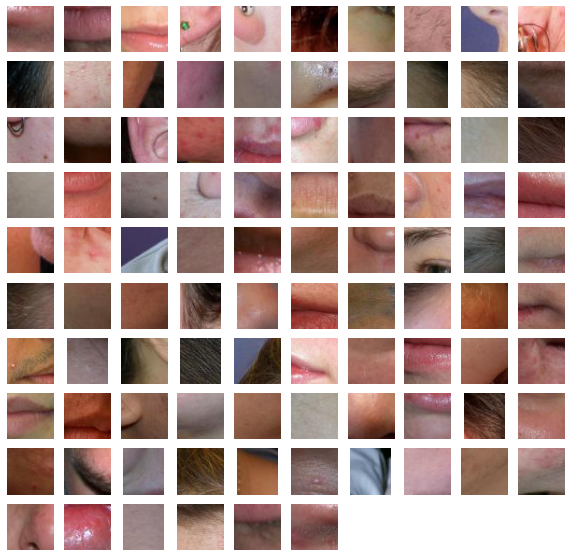

cluster 5
28 elements


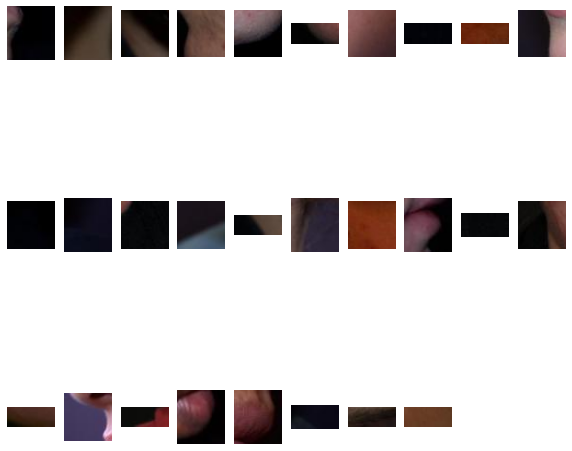

In [26]:
from sklearn.mixture import GaussianMixture

GMM1 = Clustering(
    GaussianMixture(n_components=NumCluster,random_state=1),
    dataset_1st_ReducedFeatures,
    imageFileList,
    NumCluster=NumCluster
    ).train()

GMM1.display_cluster()


# Further extract from intra group

In [27]:
# data cleaning
imageFileList_cluster=GMM1.groups[1]
print(len(imageFileList_cluster))

98


(98, 4096)
Components before PCA: 4096
Components after PCA: 30


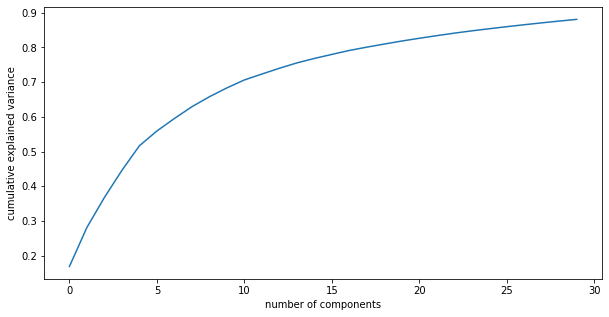

In [28]:
Cluster_ReducedFeatures = FeatureExtraction(imageFileList_cluster)\
    .getReducedFeature(n_components=30)

cluster 0
18 elements


D:\Anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


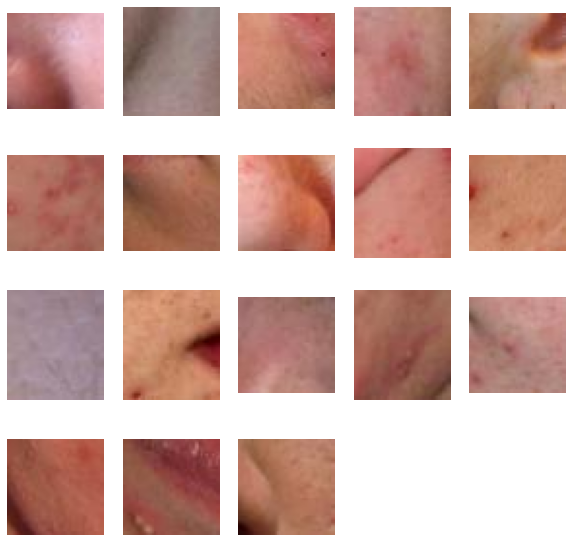

cluster 1
11 elements


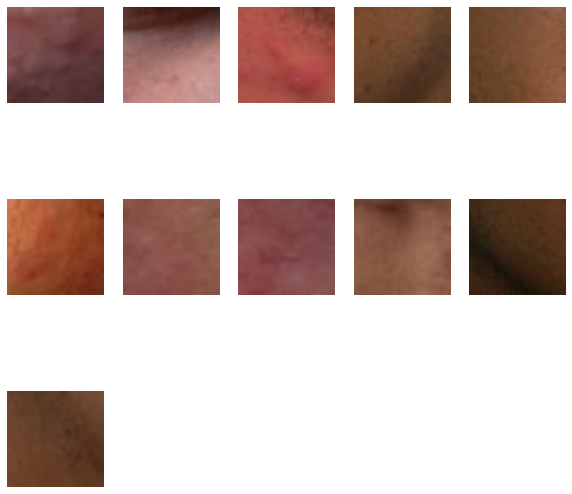

cluster 2
17 elements


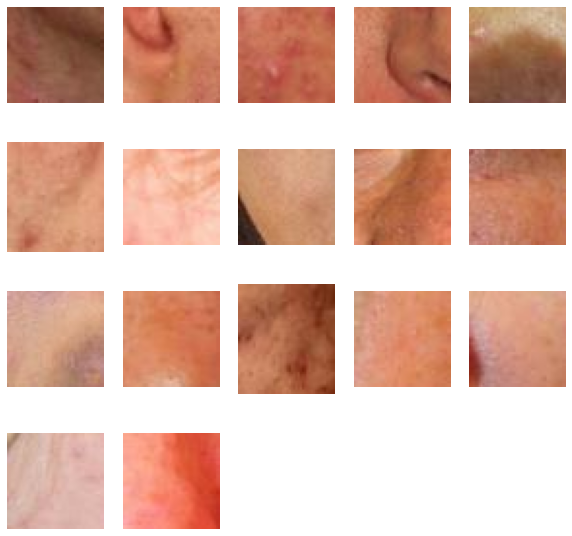

cluster 3
11 elements


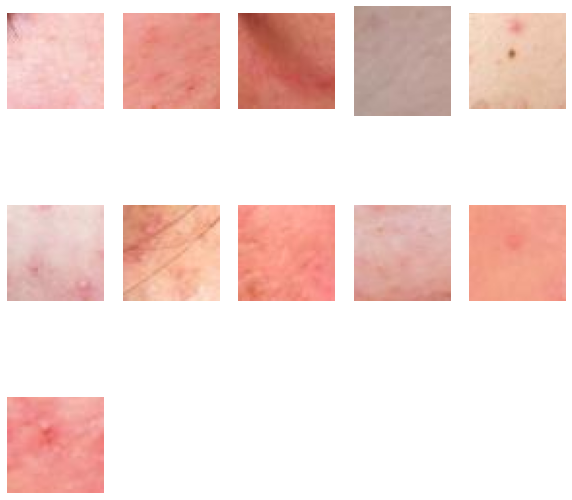

cluster 4
13 elements


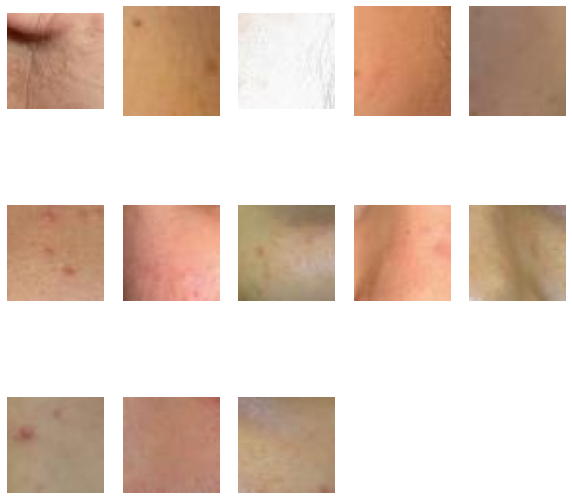

cluster 5
7 elements


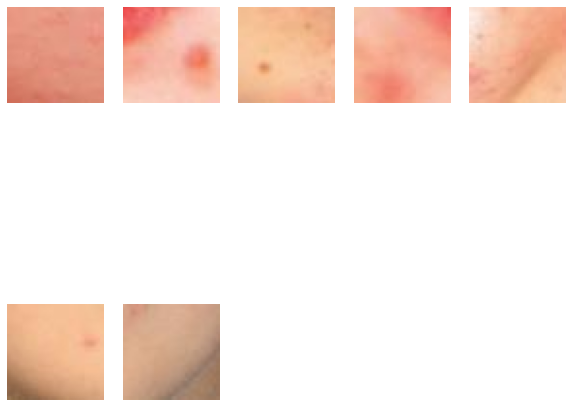

cluster 6
7 elements


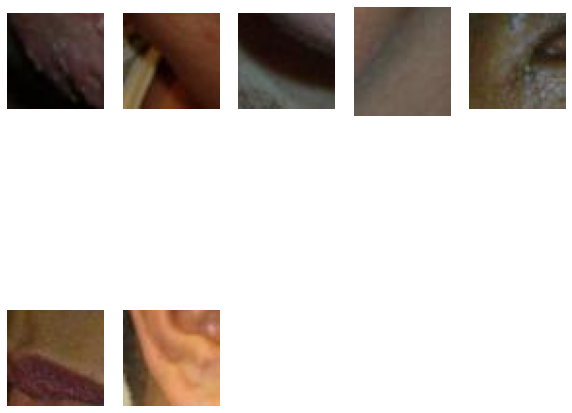

cluster 7
14 elements


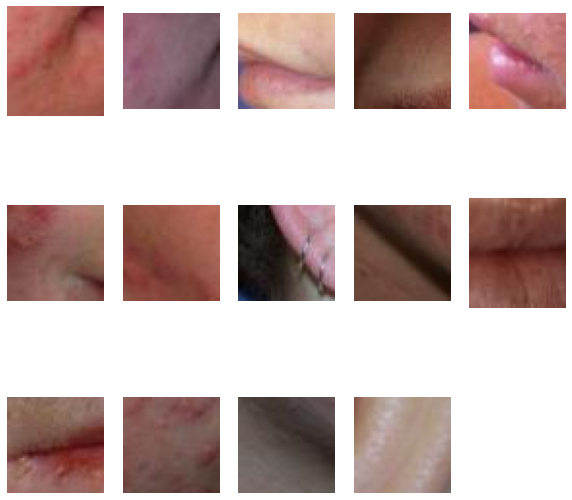

In [31]:
NumCluster = 8
GMM2 = Clustering(
    GaussianMixture(n_components=NumCluster,random_state=1),
    Cluster_ReducedFeatures,
    imageFileList_cluster,
    NumCluster=NumCluster
    ).train()

GMM2.display_cluster(no_of_col=5)

In [21]:
imageFileList_cluster=GMM2.groups[4]
print(len(imageFileList_cluster))

Cluster_ReducedFeatures = FeatureExtraction(imageFileList_cluster)\
    .getReducedFeature(n_components=10)

NumCluster = 3
GMM3 = Clustering(
    GaussianMixture(n_components=NumCluster,random_state=1),
    Cluster_ReducedFeatures,
    imageFileList_cluster,
    NumCluster=NumCluster
    ).train()

GMM3.display_cluster(no_of_col=5)

KeyError: 4

# ================================================================